In [1]:
# Preprocessing
import os
import numpy as np
import pandas as pd

DATASET_DIR = "../Dataset"
SENSOR_COLS = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

X, y = [], []

for digit in sorted(os.listdir(DATASET_DIR)):
    digit_path = os.path.join(DATASET_DIR, digit)

    for file in os.listdir(digit_path):
        if not file.endswith(".csv"):
            continue

        df = pd.read_csv(os.path.join(digit_path, file))
        X.append(df[SENSOR_COLS].values)   # (T_i, 6)
        y.append(int(digit))

y = np.array(y)


In [2]:
X[0][0]

array([ 1.9870501 ,  0.65595001, -9.3490505 ,  0.44769999, -0.31404999,
        0.18205   ])

In [3]:
# Padding sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_padded = pad_sequences(
    X,
    padding="post",     # pad at end
    dtype="float32"
)


d:\Learn\Guvi\DS\project\Air Gesture\air_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
X_padded.shape

(3000, 520, 6)

In [5]:
# stack all real values (ignore padding zeros)
all_data = np.vstack(X)

mean = all_data.mean(axis=0)
std  = all_data.std(axis=0)
std[std == 0] = 1e-6

X_padded = (X_padded - mean) / std


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout

num_classes = len(np.unique(y_train))

model = Sequential([
    Masking(mask_value=0.0, input_shape=(None, 6)),

    LSTM(64, return_sequences=True),
    Dropout(0.3),

    LSTM(64),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])


d:\Learn\Guvi\DS\project\Air Gesture\air_env\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.0908 - loss: 2.3075 - val_accuracy: 0.1000 - val_loss: 2.3039
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.0967 - loss: 2.3053 - val_accuracy: 0.1000 - val_loss: 2.3038
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.1025 - loss: 2.3042 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - accuracy: 0.0892 - loss: 2.3043 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.0942 - loss: 2.3038 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.0913 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.0908 - loss: 2.3039 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.0958 - loss: 2.3032 - val_accu

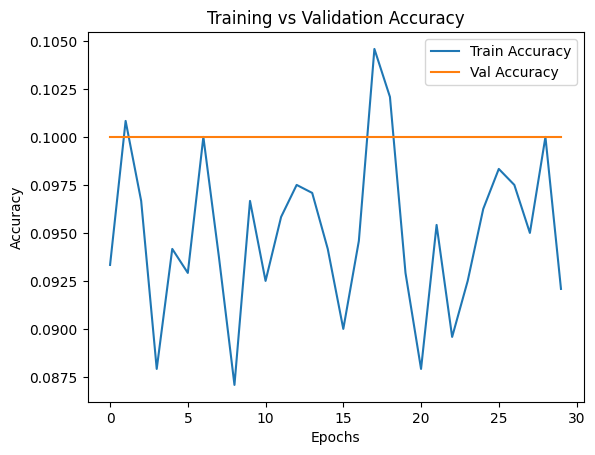

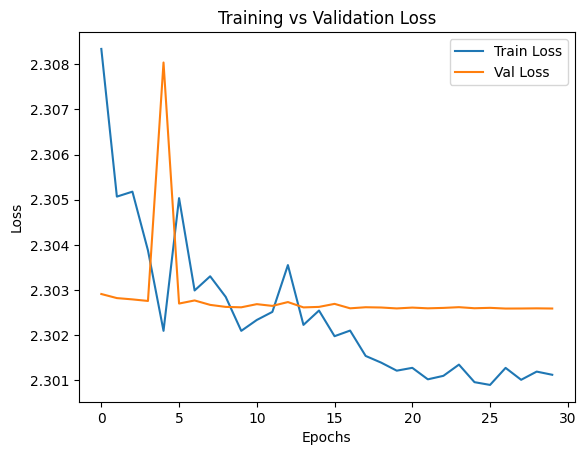

In [15]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


<Figure size 800x800 with 0 Axes>

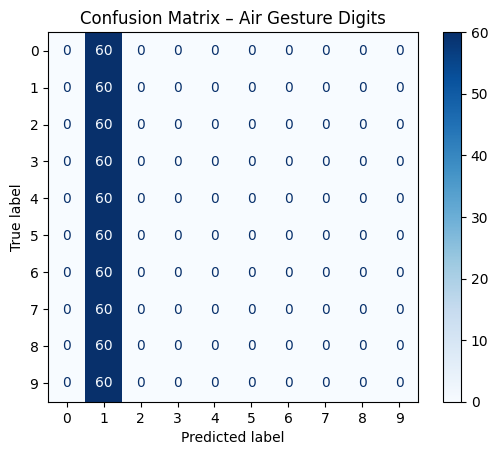

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# predictions
y_pred = np.argmax(model.predict(X_val), axis=1)

# confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(i) for i in range(10)]
)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Air Gesture Digits")
plt.show()


In [9]:
model.save("../model/air_gesture_lstm.h5")